In [1]:
%pylab inline
import pandas as pd
import numpy as np
import scipy.stats as ss
import pickle
#import matplotlib.pyplot as plt
import statsmodels
from statsmodels.tsa.api import ARIMA, acf, pacf, datetools
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
import xgboost as xgb
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [86]:
data = pd.read_csv("total_sales_day.csv", sep=';', date_parser=lambda x: pd.tseries.tools.to_datetime(x, dayfirst=True),
                   parse_dates=['day'], 
                   #index_col=['day'], 
                   usecols=['day', 'filial', 'store', 'sales'])
data.head()

,filial,store,day,sales
0,Филиал Волго-Вятский,1007,2014-01-01,1322773.88
1,Филиал Волго-Вятский,1007,2014-01-02,1779741.66
2,Филиал Волго-Вятский,1007,2014-01-03,1858412.64
3,Филиал Волго-Вятский,1007,2014-01-04,1925936.03
4,Филиал Волго-Вятский,1007,2014-01-05,1984582.99


In [87]:
unq_fil = data['filial'].unique()
print(unq_fil)

['Филиал Волго-Вятский' 'Филиал Приволжский' 'Филиал Северо-Западн'
 'Филиал Средне-Волжск' 'Филиал Уральский' 'Филиал Центрально-Че'
 'Филиал Центральный' 'Филиал Южный']


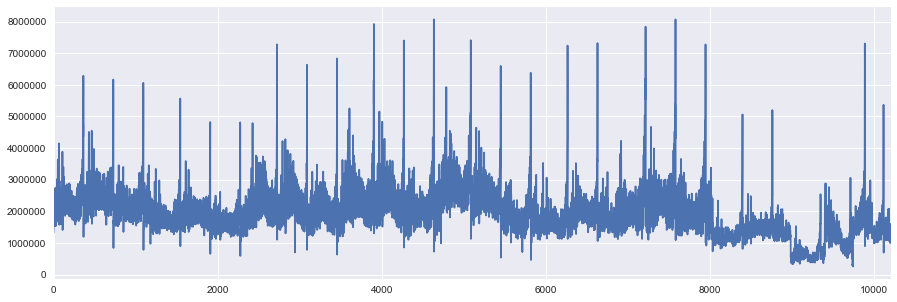

In [88]:
data[data.filial == unq_fil[0]].sales.plot()

In [112]:
#data_volg = data[data.filial == unq_fil[0]]
#data_volg.head()
data_volg = data[data.filial == unq_fil[0]].groupby('day', axis=0).sum()
data_volg.head()

,store,sales
day,,
2014-01-01,9424,9633221.37
2014-01-02,9424,15973376.83
2014-01-03,9424,16804913.01
2014-01-04,9424,16119129.99
2014-01-05,9424,15909730.42


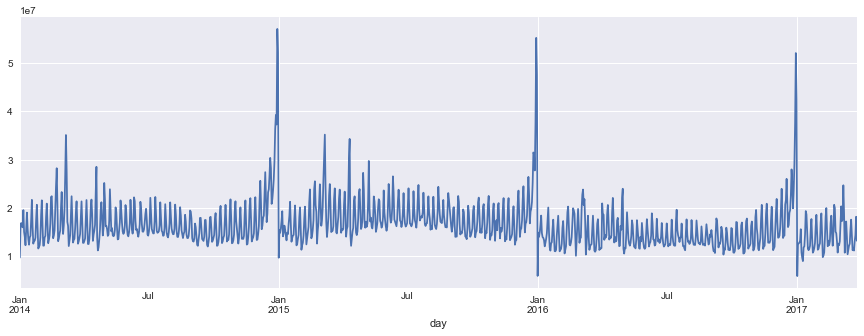

In [113]:
data_volg.sales.plot()

Критерий Дики-Фуллера: p=0.000019


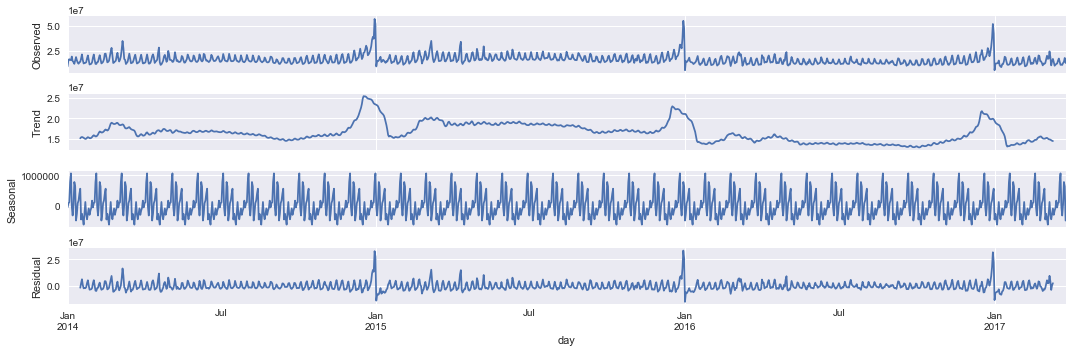

In [115]:
plt.figure(figsize(15,5))
sm.tsa.seasonal_decompose(data_volg.sales, freq=30).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_volg.sales)[1])

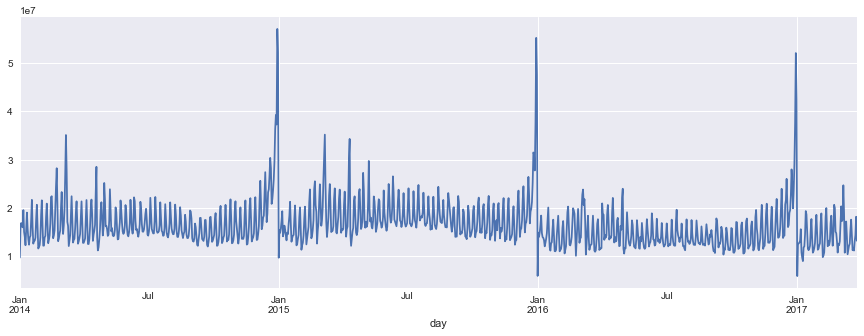

In [129]:
data_volg.sales.plot()

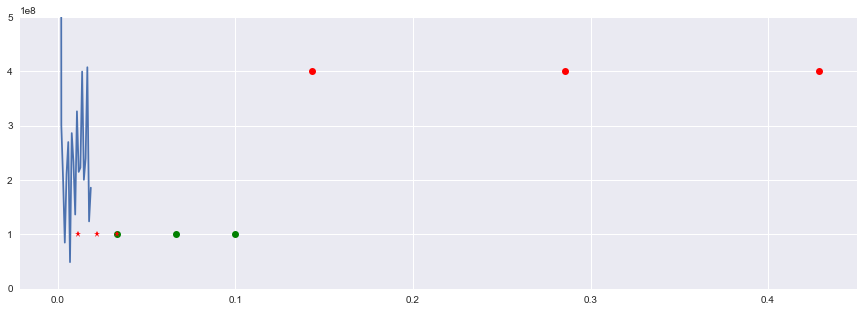

In [128]:
# Fourier Transformation
window = np.hamming(2**10)
fourier_decomp = np.fft.fft(data_volg.sales.values[:2**10]*window)
ffreq = np.absolute(np.fft.fftfreq(n=2**10))
plt.figure(figsize=(15,5))
plt.plot(ffreq[:2*10], np.abs(fourier_decomp[:2*10]))
plt.ylim([0,5e8])
for i in range(1,4):
    plt.plot(i/7.0, 4e8, 'ro');
for i in range(1,4):
    plt.plot(i/30.0, 1e8, 'go');
for i in range(1,4):
    plt.plot(i/90.0, 1e8, 'r*');

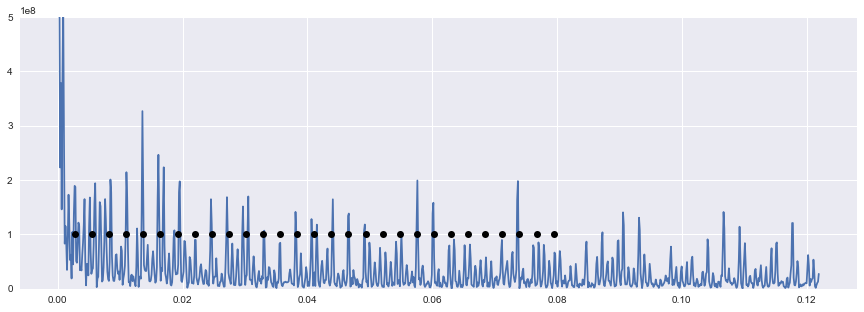

In [9]:
# Fourier Transformation
window = np.hamming(2**13)
fourier_decomp = np.fft.fft(data_volg.sales.values[:2**13]*window)
ffreq = np.absolute(np.fft.fftfreq(n=2**13))
plt.figure(figsize=(15,5))
plt.plot(ffreq[:1000], np.abs(fourier_decomp[:1000]))
plt.ylim([0,5e8])
for i in range(1,30):
    plt.plot(i/365.0, 1e8, 'ko');

In [197]:
def make_fourier_regressors(data, num_end, season=7, f_ind='week_'):
    str_var = ''
    length = data.shape[0]
    for i in range(1, num_end+1):
        sin = "s_" + f_ind + str(i)
        cos = "c_" + f_ind + str(i)
        data[sin] = np.sin(2*np.pi*i*np.arange(1, length+1)/season)
        data[cos] = np.cos(2*np.pi*i*np.arange(1, length+1)/season)
        str_var = str_var + sin + ' + '
        if i != num_end:
            str_var = str_var + cos + ' + '
        else:
            str_var = str_var + cos
    return str_var

def make_dummy_weekday(data):
    # Weekday dummy-variables
    data['monday'] = [1 if date.weekday() == 0 else 0 for date in data.index]
    data['tuesday'] = [1 if date.weekday() == 1 else 0 for date in data.index]
    data['wednessday'] = [1 if date.weekday() == 2 else 0 for date in data.index]
    data['thursday'] = [1 if date.weekday() == 3 else 0 for date in data.index]
    data['friday'] = [1 if date.weekday() == 4 else 0 for date in data.index]
    data['saturday'] = [1 if date.weekday() == 5 else 0 for date in data.index]
    data['sunday'] = [1 if date.weekday() == 6 else 0 for date in data.index]
    weekday_str = ' monday + tuesday + wednessday + thursday + friday + saturday + sunday'
    return weekday_str

def make_dummy_weekend(data, weekend, date_w, pre=0, post=0):
    str_weekend = ' '+weekend
    data[weekend] = [1 if date.month == date_w.month[0] and date.day == date_w.day[0] else 0 for date in data.index]
    for i in range(1, pre+1):
        pre_week_str = weekend+'_pre_'+str(i)
        str_weekend += ' + '+pre_week_str
        pre_date = date_w - i
        data[pre_week_str] = [1 if date.month == pre_date.month[0] and date.day == pre_date.day[0] else 0 for date in data.index]
    for i in range(1, post+1):
        pst_week_str = weekend+'_pst_'+str(i)
        str_weekend += ' + '+pst_week_str
        pst_date = date_w + i
        data[pst_week_str] = [1 if date.month == pst_date.month[0] and date.day == pst_date.day[0] else 0 for date in data.index]
    return str_weekend

"""
def linear_trend_for_period(data, date_range, name):
    size = date_range.size
    data[name] = []
    return name
"""

def fourier_prediction(data, pred_var, exog_var, train_time_limit):
    str_reg = pred_var + ' ~ '
    str_var = " + ".join(exog_var)
    print(str_reg+str_var)
    model = smf.ols(str_reg + str_var, data=data.loc[:train_time_limit])
    fitted = model.fit()
    return fitted

def fourier_prediction_old(data, train_time_limit, degree=49):
    data_c = pd.DataFrame(data.sales, columns = ['val'], index = data.index)
    str_reg = 'val ~ '
    week_day_str, str_var = '', ''
    str_var = make_fourier_regressors(data_c, degree)
    week_day_str = make_dummy_weekday(data_c)
    model = smf.ols(str_reg + str_var + week_day_str, data=data_c.loc[:train_time_limit])
    fitted = model.fit(cov_type='HC1')
    #regressor = ElasticNet(alpha=0.1, l1_ratio=0.6)
    #regressor.fit(data_c.loc[:train_time_limit].drop(['val'], axis=1), data_c.loc[:train_time_limit].val)
    return fitted.predict(data_c)
    #return regressor.predict(data_c.drop(['val'], axis=1))

In [259]:
# Fourier construction
data_volg_cp = data_volg.loc['2014-01-01':].copy()
#str_weekday = make_dummy_weekday(data_volg_cp)
#str_week = make_fourier_regressors(data_volg_cp, 5, season=7, f_ind='week_')
str_month = make_fourier_regressors(data_volg_cp, 5, season=30.41, f_ind='month_')
str_year = make_fourier_regressors(data_volg_cp, 15, season=365.0, f_ind='year_')
str_new_year = make_dummy_weekend(data_volg_cp, 'new_year', pd.date_range('2017-01-01',periods=1,freq='D'), 7, 7)
str_weekends = str_new_year

In [260]:
fourier_model = fourier_prediction(data_volg_cp, 'sales',
                                   #[str_week, str_weekday, str_month, str_year, str_weekends],
                                   [str_month, str_year, str_weekends],
                                   '2016-12-31')

sales ~ s_month_1 + c_month_1 + s_month_2 + c_month_2 + s_month_3 + c_month_3 + s_month_4 + c_month_4 + s_month_5 + c_month_5 + s_year_1 + c_year_1 + s_year_2 + c_year_2 + s_year_3 + c_year_3 + s_year_4 + c_year_4 + s_year_5 + c_year_5 + s_year_6 + c_year_6 + s_year_7 + c_year_7 + s_year_8 + c_year_8 + s_year_9 + c_year_9 + s_year_10 + c_year_10 + s_year_11 + c_year_11 + s_year_12 + c_year_12 + s_year_13 + c_year_13 + s_year_14 + c_year_14 + s_year_15 + c_year_15 +  new_year + new_year_pre_1 + new_year_pre_2 + new_year_pre_3 + new_year_pre_4 + new_year_pre_5 + new_year_pre_6 + new_year_pre_7 + new_year_pst_1 + new_year_pst_2 + new_year_pst_3 + new_year_pst_4 + new_year_pst_5 + new_year_pst_6 + new_year_pst_7


C:\ProgramData\Anaconda3\lib\site-packages\patsy\util.py:652: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  return safe_is_pandas_categorical_dtype(data.dtype)
C:\ProgramData\Anaconda3\lib\site-packages\patsy\util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):


In [261]:
prediction = fourier_model.predict(data_volg_cp.loc['2014-01-01':])

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:775: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  exog = dmatrix(self.model.data.design_info.builder,
C:\ProgramData\Anaconda3\lib\site-packages\patsy\util.py:679: DeprecationWarning: pandas.core.common.is_categorical_dtype is deprecated. import from the public API: pandas.api.types.is_categorical_dtype instead
  if safe_is_pandas_categorical_dtype(dt1):


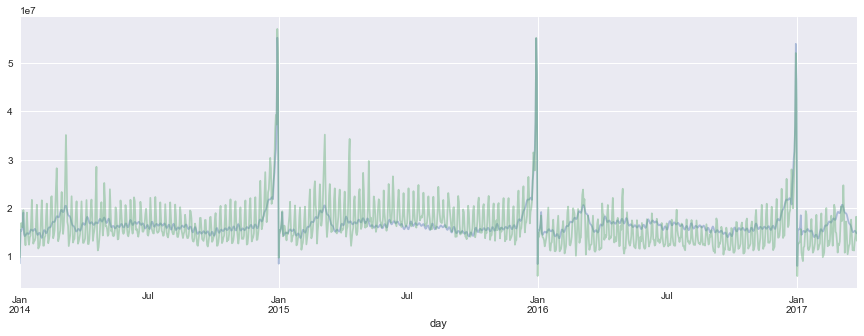

In [262]:
prediction.plot(alpha=0.4)
data_volg_cp.sales.plot(alpha=0.4)

In [263]:
print(fourier_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     19.41
Date:                Sun, 02 Apr 2017   Prob (F-statistic):          4.38e-123
Time:                        17:27:31   Log-Likelihood:                -18036.
No. Observations:                1096   AIC:                         3.618e+04
Df Residuals:                    1040   BIC:                         3.646e+04
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.639e+07   1.21e+05    135.

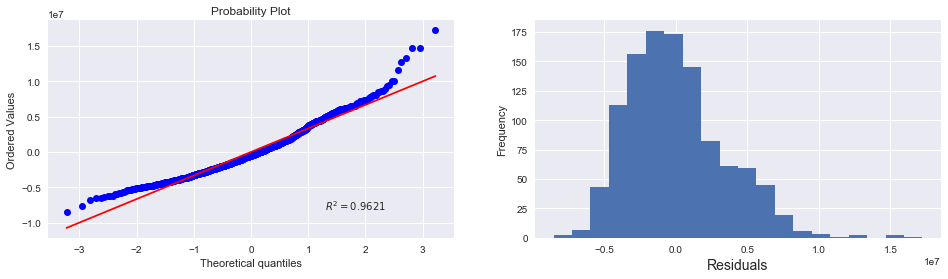

In [264]:
# Residuals
plt.figure(figsize(16,4))
plt.subplot(121)
ss.probplot(fourier_model.resid, dist="norm", plot=pylab, rvalue=True)
plt.subplot(122)
fourier_model.resid.plot.hist(bins=20)
plt.xlabel('Residuals', fontsize=14)
pylab.show()

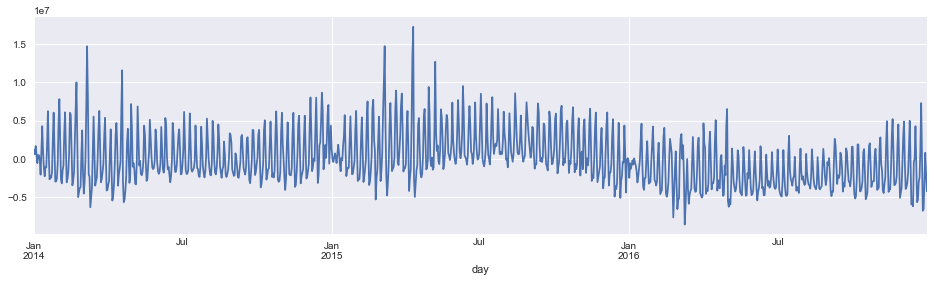

In [265]:
fourier_model.resid.plot();

Критерий Дики-Фуллера: p=0.730473


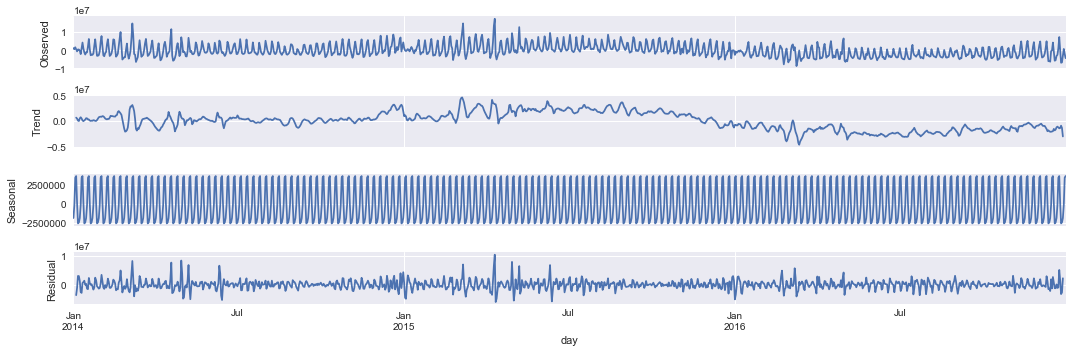

In [266]:
plt.figure(figsize(15,5))
sm.tsa.seasonal_decompose(fourier_model.resid, freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(fourier_model.resid)[1])

### Using SARIMAX for prediction

Осталась только недельная сезонность.

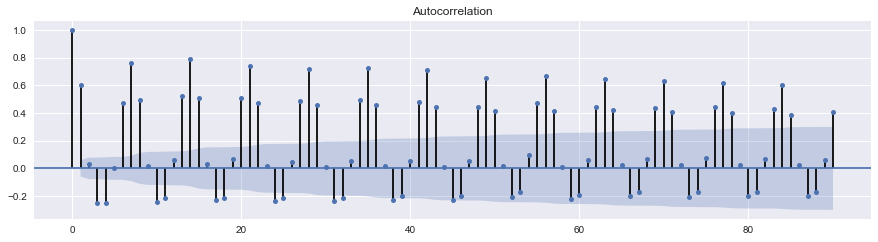

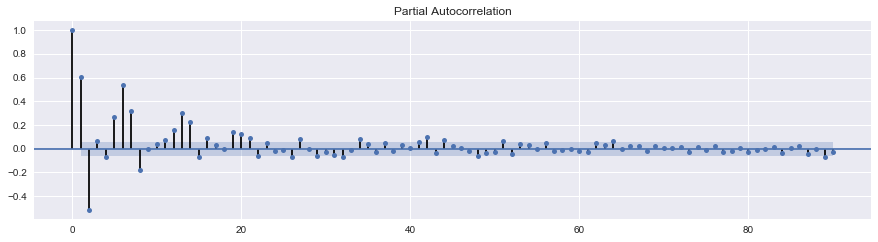

In [267]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(fourier_model.resid.values.squeeze(), lags=90, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(fourier_model.resid.values.squeeze(), lags=90, ax=ax)
pylab.show()

In [268]:
resid = pd.DataFrame(fourier_model.resid, columns=['val'])
resid['diff_s1'] = resid.val - resid.val.shift(7)

Критерий Дики-Фуллера: p=0.000000


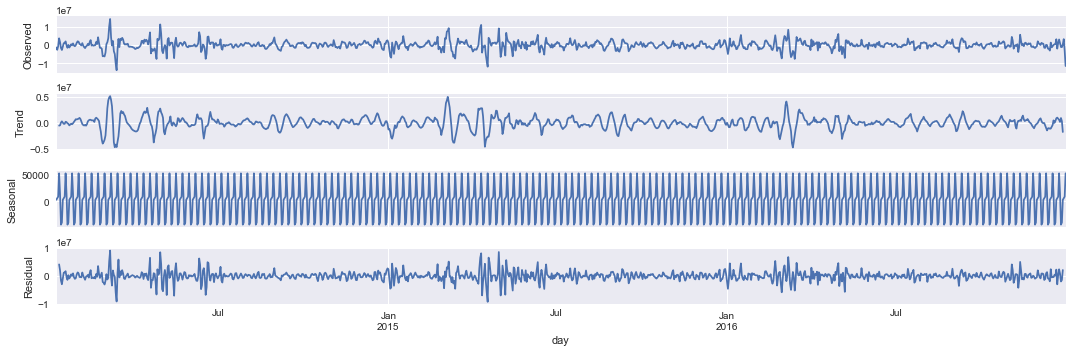

In [269]:
plt.figure(figsize(15,5))
sm.tsa.seasonal_decompose(resid.diff_s1[7:], freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(resid.diff_s1[7:])[1])

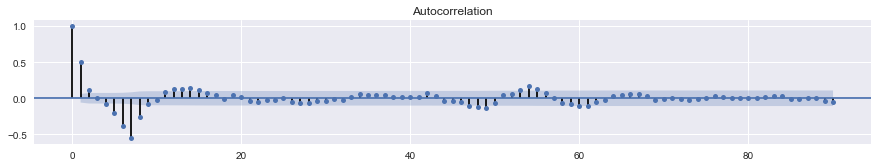

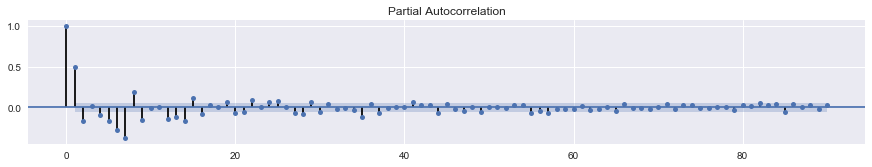

In [270]:
plt.figure(figsize(15,5))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid.diff_s1[7:].values.squeeze(), lags=90, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid.diff_s1[7:].values.squeeze(), lags=90, ax=ax)
pylab.show()

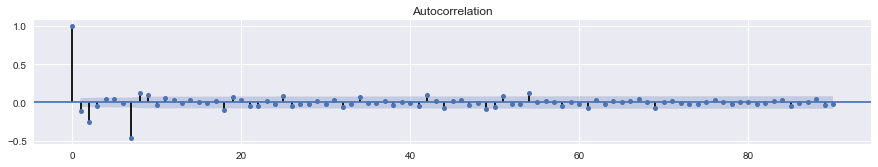

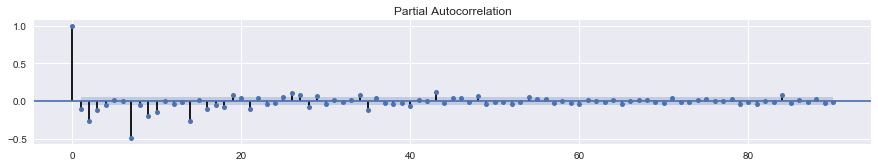

In [271]:
resid['diff_s1_d1'] = resid.diff_s1 - resid.diff_s1.shift(1)
plt.figure(figsize(15,5))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid.diff_s1_d1[8:].values.squeeze(), lags=90, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid.diff_s1_d1[8:].values.squeeze(), lags=90, ax=ax)
pylab.show()

Критерий Дики-Фуллера: p=0.000000


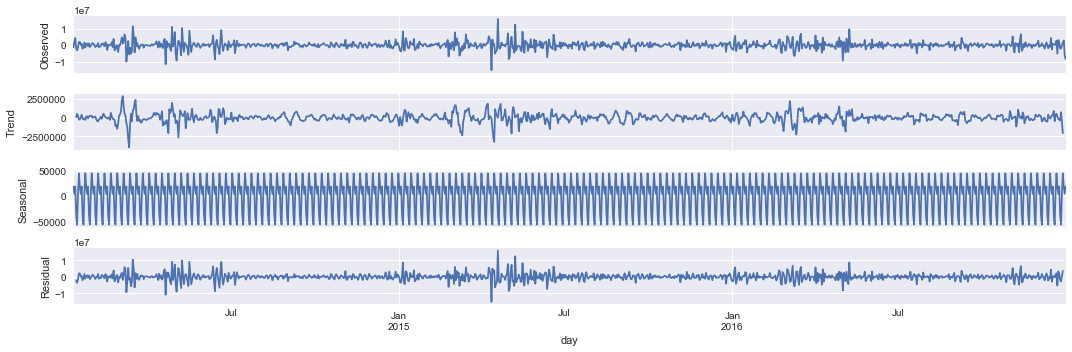

In [272]:
plt.figure(figsize(15,5))
sm.tsa.seasonal_decompose(resid.diff_s1_d1[8:], freq=7).plot();
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(resid.diff_s1_d1[8:])[1])

In [273]:
from itertools import product

In [274]:
ps = range(0, 2)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [275]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

In [309]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data_volg_cp.loc['2014-01-01':'2017-01-01'].sales, 
                                        exog=data_volg_cp.loc['2014-01-01':'2017-01-01'][data_volg_cp.columns[2:]], 
                                        order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
        # Without exog
        """model = sm.tsa.statespace.SARIMAX(resid.val.loc['2014-01-01':'2016-12-31'],
                                          order=(param[0], d, param[1]), 
                                          seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)"""
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
Wall time: 2min 29s


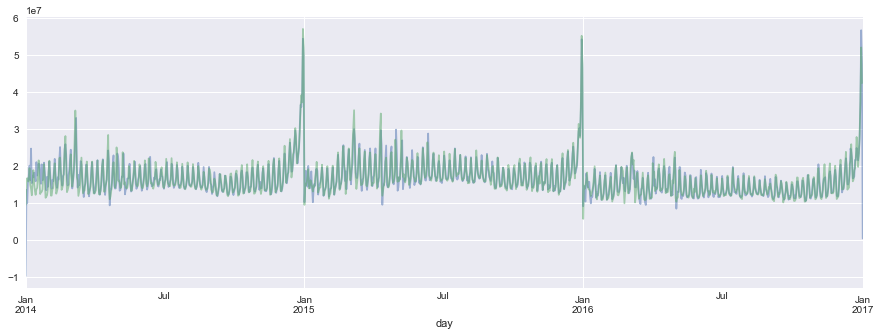

In [310]:
best_model.fittedvalues.plot(alpha=0.5)
data_volg_cp.loc['2014-01-01':'2016-12-31'].sales.plot(alpha=0.5)

In [311]:
forecast = best_model.forecast(steps=31, exog=data_volg_cp[data_volg_cp.columns[2:]].loc['2017-01-01':'2017-01-31'])

In [314]:
forecast = best_model.predict('2017-01-01', '2017-03-26', 
                              exog=data_volg_cp[data_volg_cp.columns[2:]].loc['2017-01-02':'2017-03-26'])

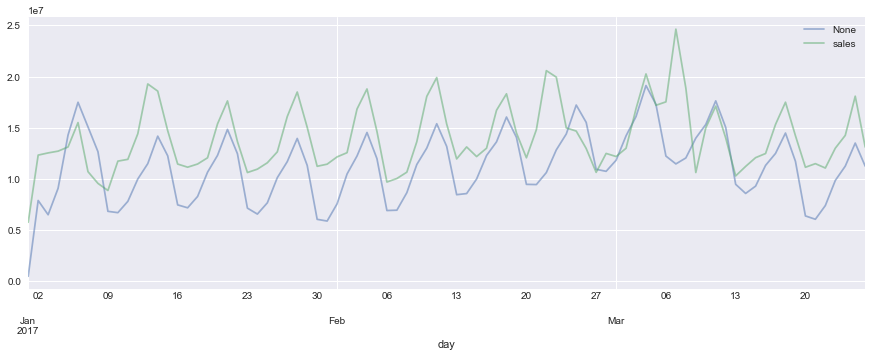

In [315]:
fig, ax = plt.subplots()
forecast.plot(alpha=0.5, legend='Forecast', ax=ax)
data_volg_cp.sales.loc['2017-01-01':'2017-03-26'].plot(alpha=0.5, legend='True', ax=ax)

In [281]:
# If we didn't use exog
"""pred = pd.DataFrame(np.zeros((data_volg_cp.loc[:'2016-12-31'].shape[0], 1)), 
                    columns = ['val'], 
                    index=data_volg_cp.loc[:'2016-12-31'].index)
for index in fourier_model.params.index:
    if index == 'Intercept':
        pred['val'] += fourier_model.params[index]
        continue
    pred['val'] += (data_volg_cp.loc[:'2016-12-31'][index]*fourier_model.params[index]).values
pred.plot()"""

"pred = pd.DataFrame(np.zeros((data_volg_cp.loc[:'2016-12-31'].shape[0], 1)), \n                    columns = ['val'], \n                    index=data_volg_cp.loc[:'2016-12-31'].index)\nfor index in fourier_model.params.index:\n    if index == 'Intercept':\n        pred['val'] += fourier_model.params[index]\n        continue\n    pred['val'] += (data_volg_cp.loc[:'2016-12-31'][index]*fourier_model.params[index]).values\npred.plot()"

In [282]:
# If we didn't use exog
"""(best_model.fittedvalues + pred.val).loc['2014-01-01':].plot(alpha=0.5)
data_volg_cp.loc['2014-01-01':'2016-12-31'].sales.plot(alpha=0.5)"""

"(best_model.fittedvalues + pred.val).loc['2014-01-01':].plot(alpha=0.5)\ndata_volg_cp.loc['2014-01-01':'2016-12-31'].sales.plot(alpha=0.5)"

### Regression prediction

In [56]:
# 30 Month regressors

In [ ]:
data_volg_cp = data_volg.loc['2014-01-01':].copy()
# Weekday dummy
make_dummy_weekday(data_volg_cp)

# Fourier components
make_fourier_regressors(data_volg_cp, 5, season=7, f_ind='week_')
make_fourier_regressors(data_volg_cp, 5, season=30.41, f_ind='month_')
make_fourier_regressors(data_volg_cp, 15, season=365.0, f_ind='year_')

# Weekends dummy variable
make_dummy_weekend(data_volg_cp, 'new_year', pd.date_range('2017-01-01',periods=1,freq='D'), 7, 7)

# December trend variable ?

# Rolling sums
data_volg_cp['week_sum'] = data_volg_cp.sales.rolling(7).sum().fillna(0)
data_volg_cp['week_2_sum'] = data_volg_cp.sales.rolling(14).sum().fillna(0)
data_volg_cp['month_sum'] = data_volg_cp.sales.rolling(30).sum().fillna(0)

# Previous data features
K_d = 5
K_w = 2
offset = max(K_d, 7*K_w)

for day_lag in range(1, K_d):
        data_volg_cp['day_lag_'+str(day_lag)] = [0]*offset + data_volg_cp[offset-day_lag:-day_lag]['sales'].values.tolist()
for week_lag in range(1, K_w):
        data_volg_cp['week_lag_'+str(day_lag)] = [0]*offset + \
                                                 data_volg_cp[offset-7*week_lag:-7*week_lag]['sales'].values.tolist()

